<a href="https://colab.research.google.com/github/Talendar/stocks_prices_prediction/blob/main/stocks_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction of Stocks Prices with Deep Learning**

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, Javascript
import os

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
tf.keras.backend.set_floatx('float64')

!pip install yahooquery
from yahooquery import Ticker

!rm -rf stocks
!git clone https://github.com/Talendar/stocks_prices_prediction stocks

%load_ext autoreload
%autoreload 2

from stocks.aux.stocks_data import StocksData
from stocks.aux.eval import *
from stocks.aux.normalization import *
from stocks.aux.tf_callbacks import ClearCallback

In [33]:
NUM_SESSIONS = 5  # number of previous trading sessions the model will analyse in order to make a prediction
NORMALIZE_LABELS = True

TRAIN_PC, VAL_PC, TEST_PC = 0.85, 0.1, 0.05
assert (TRAIN_PC + VAL_PC + TEST_PC) == 1

LABELS_NAMES = [    # values that the model will try to predict
    "open", "low", "high",
]

## **1) Preparing the data**

#### **1.1) Fetching stocks prices**

   [TIME INTERVAL] from 2007-01-02 to 2020-12-07
[TRADING SESSIONS] 3441

>>> DATA:


,open,low,close,high,volume,adjclose
date,,,,,,
2007-01-02,44476.0,44476.000000,45383.000000,45388.000000,75560200.0,45383.000000
2007-01-03,45379.0,44284.000000,44445.000000,45379.000000,122372800.0,44445.000000
2007-01-04,44442.0,43623.000000,44020.000000,44442.000000,86577000.0,44020.000000
2007-01-05,44019.0,42160.000000,42245.000000,44081.000000,164055000.0,42245.000000
2007-01-08,42249.0,42144.000000,42830.000000,42926.000000,114007100.0,42830.000000
...,...,...,...,...,...,...
2020-12-01,108897.0,108897.000000,111335.000000,111840.000000,11324800.0,111335.000000
2020-12-02,111402.0,110579.000000,111814.000000,112315.000000,9814300.0,111814.000000
2020-12-03,111874.0,111874.000000,112919.000000,113377.000000,11474200.0,112919.000000




>>> STATS:


,open,low,close,high,volume,adjclose
count,3441.000000,3441.000000,3441.000000,3441.000000,3.441000e+03,3441.000000
mean,64568.331444,63899.225568,64588.584648,65241.841627,8.223386e+06,64588.584648
std,17568.057633,17483.078444,17590.460783,17668.235206,2.272712e+07,17590.460783
min,29438.000000,29435.000000,29435.000000,31480.000000,0.000000e+00,29435.000000
25%,52758.000000,52190.000000,52764.000000,53312.000000,2.242400e+06,52764.000000
50%,60416.000000,59815.000000,60452.000000,61188.000000,3.307200e+06,60452.000000
75%,70377.000000,69698.000000,70385.000000,70958.000000,4.574900e+06,70385.000000
max,119528.000000,118108.000000,119528.000000,119593.000000,2.322653e+08,119528.000000


<IPython.core.display.Javascript object>

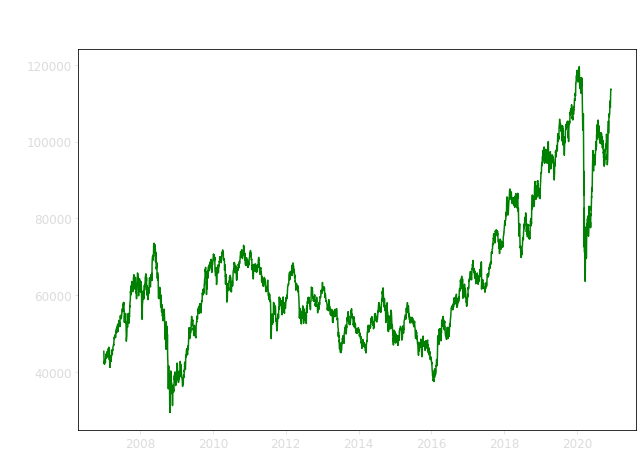

In [34]:
data = Ticker("^BVSP").history(start="2007-01-01",
                               #end="2017-12-31",
                               #period="max",
                               interval="1d")
data.reset_index("symbol", inplace=True, drop=True)

print("   [TIME INTERVAL] from %s to %s" % (data.index[0], data.index[-1]))
print("[TRADING SESSIONS] %d\n" % len(data))

print(">>> DATA:")
display(data)

print("\n\n>>> STATS:")
display(data.describe())

print("\n\n")
ax = data["close"].plot(figsize=(10,7), color="green")
ax.set_title("Evolution of the closing prices\n", fontsize=20, color="#ffffff");
ax.set_ylabel("Closing prices", fontsize="15", color="#ffffff");
ax.set_xlabel("Date", fontsize="15", color="#ffffff");

Javascript("google.colab.output.setIframeHeight('500px');")

#### **1.2) Pre-processing data**

In [35]:
data = StocksData(
    data_df=data,
    num_sessions=NUM_SESSIONS,
    labels_names=LABELS_NAMES,
    feature_normalization=(zscore_norm, zscore_denorm), 
    label_normalization=(zscore_norm, zscore_denorm) \
                        if NORMALIZE_LABELS else None,  
    data_split_pc=(TRAIN_PC, VAL_PC, TEST_PC),
)

print("  [TRAINING RANGE] %s to %s" % (
    data.raw_train["features"].index[0], data.raw_train["features"].index[-1]))
print("[VALIDATION RANGE] %s to %s" % (
    data.raw_val["features"].index[0], data.raw_val["features"].index[-1]))
print("      [TEST RANGE] %s to %s" % (
    data.raw_test["features"].index[0], data.raw_test["features"].index[-1]))

  [TRAINING RANGE] 2007-01-02 to 2018-10-23
[VALIDATION RANGE] 2018-10-24 to 2020-03-20
      [TEST RANGE] 2020-03-23 to 2020-11-30


In [36]:
print(">>> NORMALIZED TRAINING DATA:")
display(data.norm_train["features"].tail())

print("\n\n>>> NORMALIZED VALIDATION DATA:")
display(data.norm_val["features"].tail())

print("\n\n>>> NORMALIZED TEST DATA:")
display(data.norm_test["features"].tail())

Javascript("google.colab.output.setIframeHeight('300px');")

>>> NORMALIZED TRAINING DATA:


,open,low,close,high,volume
date,,,,,
2018-10-17,2.609149,2.590994,2.610943,2.595935,-0.146626
2018-10-18,2.613572,2.485521,2.426751,2.556781,-0.178021
2018-10-19,2.429440,2.468326,2.462590,2.479243,-0.191492
2018-10-22,2.465689,2.521639,2.594897,2.557936,-0.186612
2018-10-23,2.597707,2.503388,2.566360,2.540908,-0.165728




>>> NORMALIZED VALIDATION DATA:


,open,low,close,high,volume
date,,,,,
2020-03-16,2.306364,1.237609,1.208514,2.249418,0.177729
2020-03-17,1.211473,1.230693,1.539905,1.738589,0.262910
2020-03-18,1.538200,0.535605,0.797951,1.480866,0.336216
2020-03-19,0.798496,0.357318,0.936023,1.047479,0.311580
2020-03-20,0.938976,0.782767,0.814670,1.256813,0.271294




>>> NORMALIZED TEST DATA:


,open,low,close,high,volume
date,,,,,
2020-11-24,4.692203,4.744364,4.919050,4.884469,0.140662
2020-11-25,4.923738,4.932065,4.952390,4.946038,0.003839
2020-11-26,4.957103,4.941959,4.961422,4.912271,-0.093514
2020-11-27,4.966334,5.013332,4.994859,5.042912,0.012998
2020-11-30,5.001814,4.885380,4.832767,4.978554,0.439682


<IPython.core.display.Javascript object>

In [37]:
sample_x, sample_y = next(iter(data.train_ds))
print(f"Sample input shape: {sample_x.shape}")
print(f"Sample label shape: {sample_y.shape}")

Sample input shape: (32, 5, 5)
Sample label shape: (32, 3)


## **2) Defining a model**

In [39]:
class MultiLSTM(tf.keras.Model):
    """ Custom LSTM model. """

    def __init__(self, num_sessions=NUM_SESSIONS):
        super(MultiLSTM, self).__init__()
        self._num_sessions = num_sessions

        self._open_predictor = model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.LSTM(128, return_sequences=False),
            tf.keras.layers.Dropout(0.5),
            #tf.keras.layers.Dense(64, activation="relu"),  
            #tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation="linear"),  
        ])

        self._pre_lowest = tf.keras.layers.LSTM(128, return_sequences=True)
        self._lowest_predictor = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.LSTM(128, return_sequences=False),
            tf.keras.layers.Dropout(0.5),
            #tf.keras.layers.Dense(64, activation="relu"),  
            #tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation="linear"), 
        ])

        self._pre_highest = tf.keras.layers.LSTM(128, return_sequences=True)
        self._highest_predictor = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.LSTM(128, return_sequences=False),
            tf.keras.layers.Dropout(0.5),
            #tf.keras.layers.Dense(64, activation="relu"),  
            #tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation="linear"),
        ])

    def call(self, inputs, training=None):
        # calculating the opening price
        open_price = self._open_predictor(inputs, training=training)

        # cloning prices: expanding shape from (batches, 1) to (batches, NUM_SESSIONS, 1)
        open_price_exp = tf.tile(tf.expand_dims(open_price, -1),   
                                 [1, self._num_sessions, 1])

        # calculating the lowest price
        lowest_price = self._lowest_predictor(
            # appends the opening price to the end of each item in the input sequence
            tf.concat([self._pre_lowest(inputs), open_price_exp], -1),
            training=training,
        )

        # cloning prices: expanding shape from (batches, 1) to (batches, NUM_SESSIONS, 1)
        lowest_price_exp = tf.tile(tf.expand_dims(lowest_price, -1),   
                                   [1, self._num_sessions, 1])

        # calculating the highest price
        highest_price = self._highest_predictor(
            # appends the opening price and the lowest price to the end of each item in the input sequence
            tf.concat(
                [self._pre_highest(inputs), open_price_exp, lowest_price_exp], -1),
            training=training,
        )

        # returning the concatenation of the opening price, lowest price and highest price
        return tf.concat([open_price, lowest_price, highest_price], -1)

In [40]:
# testing output shape
x, y = next(iter(data.train_ds))
MultiLSTM()(x).shape

TensorShape([32, 3])

## **3) Training the model**


Epoch 00200: val_loss did not improve from 0.87405
91/91 [==============================] - 1s 16ms/step - loss: 0.0462 - val_loss: 0.8796





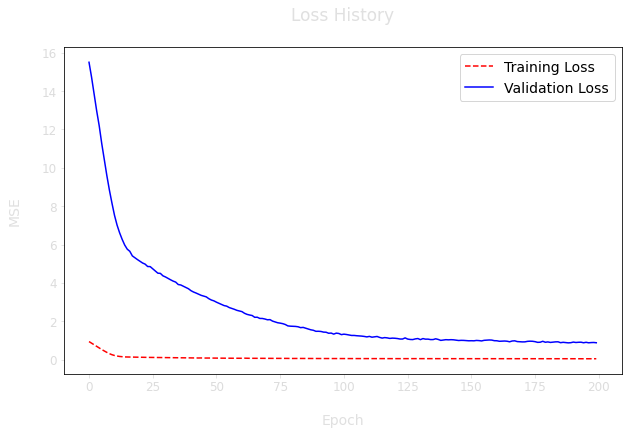

In [29]:
ck_path = os.path.dirname("./training_1/best_model.ckpt")

# building and compiling
model = MultiLSTM()
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=1e-5),
              metrics=[])
                       #tf.metrics.MeanAbsoluteError()]) 
                       #tf.metrics.MeanAbsolutePercentageError()])

# training
epochs = 200
history = model.fit(data.train_ds.shuffle(buffer_size=len(data.train_ds)), 
                    validation_data=data.val_ds,
                    epochs=epochs,
                    callbacks=[ClearCallback(),
                               ModelCheckpoint(ck_path, monitor='val_loss', 
                                               verbose=1, save_best_only=True)])

# restoring the checkpoint of the best model
model.load_weights(ck_path)

# visualizing loss history
print("\n\n")
plt.rc('xtick',labelsize=12, color="#DCDCDC")
plt.rc('ytick',labelsize=12, color="#DCDCDC")
plt.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), history.history["loss"], 'r--')
plt.plot(range(epochs), history.history["val_loss"], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])

plt.title("Loss History\n", fontsize=17, color="#E0E0E0")
plt.ylabel('MSE\n', fontsize=14, color="#E0E0E0")
plt.xlabel('\nEpoch', fontsize=14, color="#E0E0E0")
plt.show();

## **3) Evaluating the model**

#### **3.1) Training data**

     Training Data

#########################

[> GENERAL <]
   . MAE:   1225
   . MAPE:  2.1808%
   . MSE:   2475509

#########################

[> OPEN <]
   . MAE:   1225
   . MAPE:  2.1807%
   . MSE:   2475319
   . Tendency Accuracy:  52.3072%

#########################

[> LOW <]
   . MAE:   1225
   . MAPE:  2.1808%
   . MSE:   2475506
   . Tendency Accuracy:  47.2796%

#########################

[> HIGH <]
   . MAE:   1225
   . MAPE:  2.1808%
   . MSE:   2475509
   . Tendency Accuracy:  46.8320%

#########################


<IPython.core.display.Javascript object>

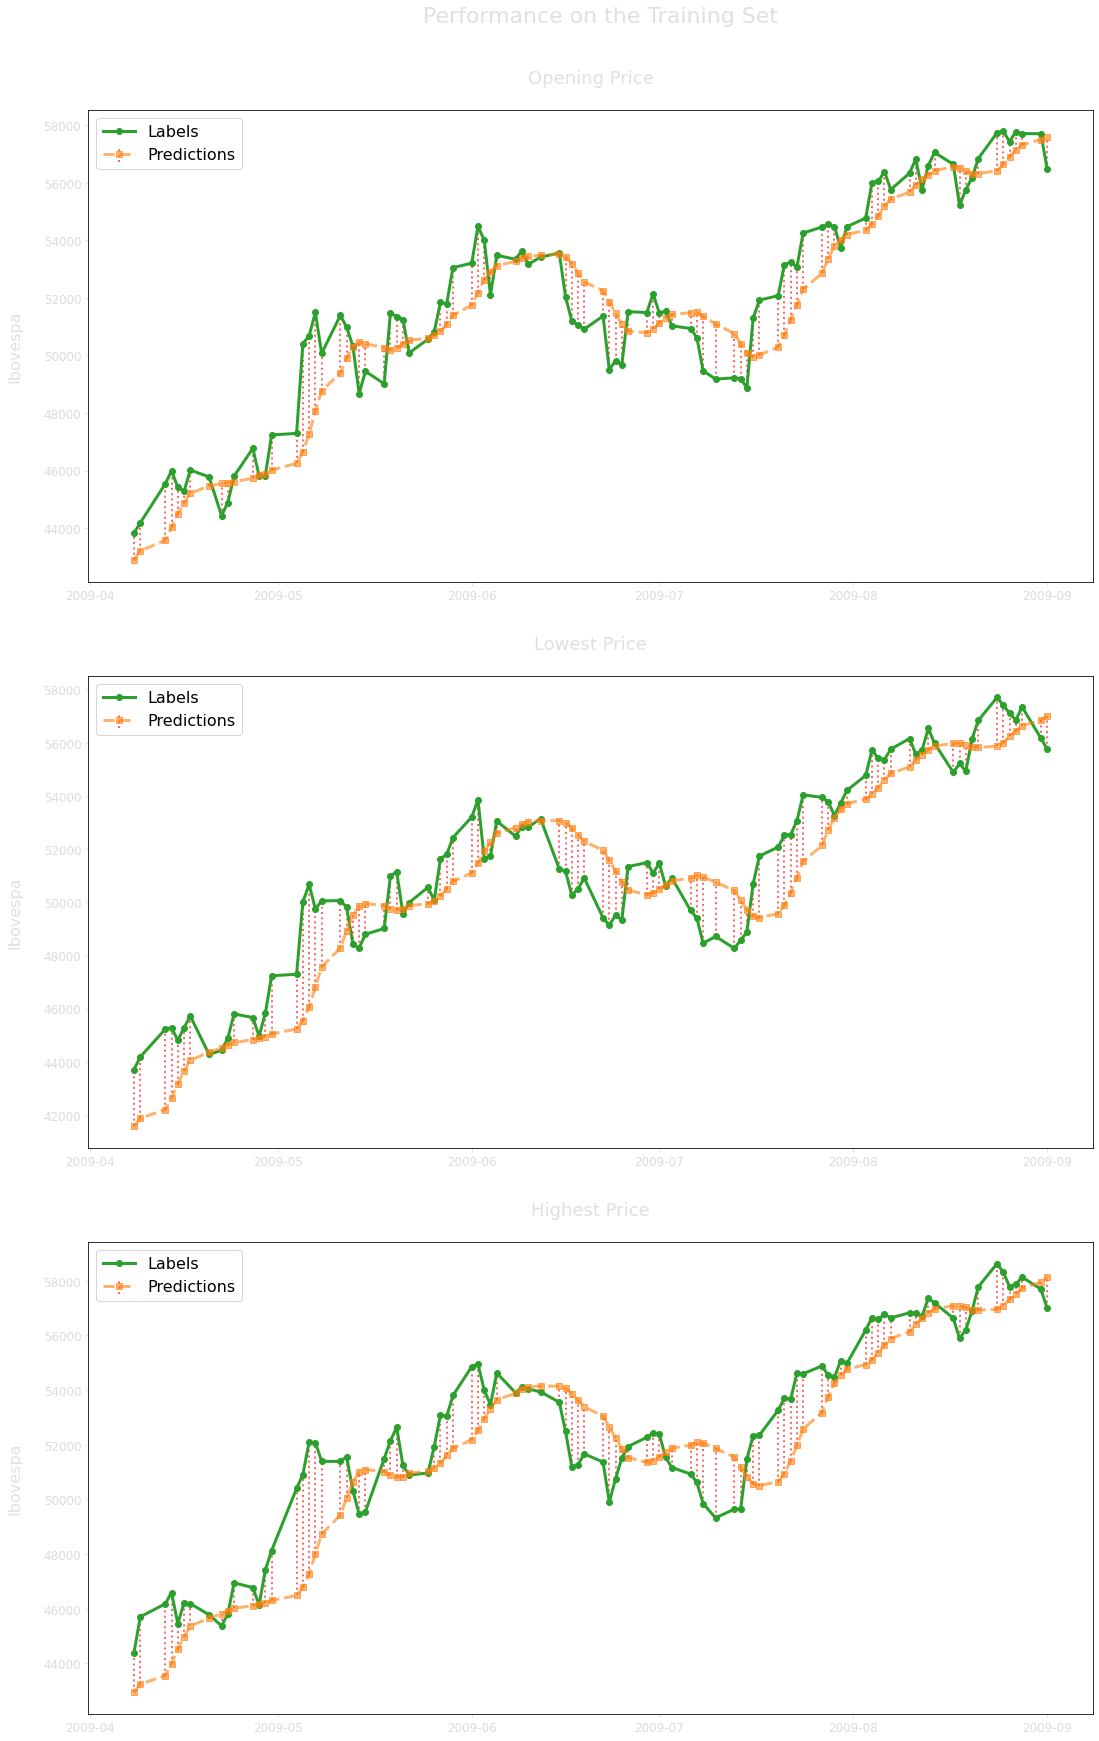

In [30]:
train_predictions, train_results = eval(model, data, "train")

print("     Training Data\n")
eval_print(train_results)

eval_plot(train_predictions, 
          data.raw_train["labels"], 
          start_date="random", 
          plot_samples=100, 
          title="Performance on the Training Set")

Javascript("google.colab.output.setIframeHeight('600px');")

#### **3.2) Validation data**

     Validation Data

#########################

[> GENERAL <]
   . MAE:   1912
   . MAPE:  2.7278%
   . MSE:   12038679

#########################

[> OPEN <]
   . MAE:   1913
   . MAPE:  2.7288%
   . MSE:   12053993
   . Tendency Accuracy:  49.1018%

#########################

[> LOW <]
   . MAE:   1915
   . MAPE:  2.7307%
   . MSE:   12089091
   . Tendency Accuracy:  44.0120%

#########################

[> HIGH <]
   . MAE:   1917
   . MAPE:  2.7322%
   . MSE:   12115402
   . Tendency Accuracy:  48.2036%

#########################


<IPython.core.display.Javascript object>

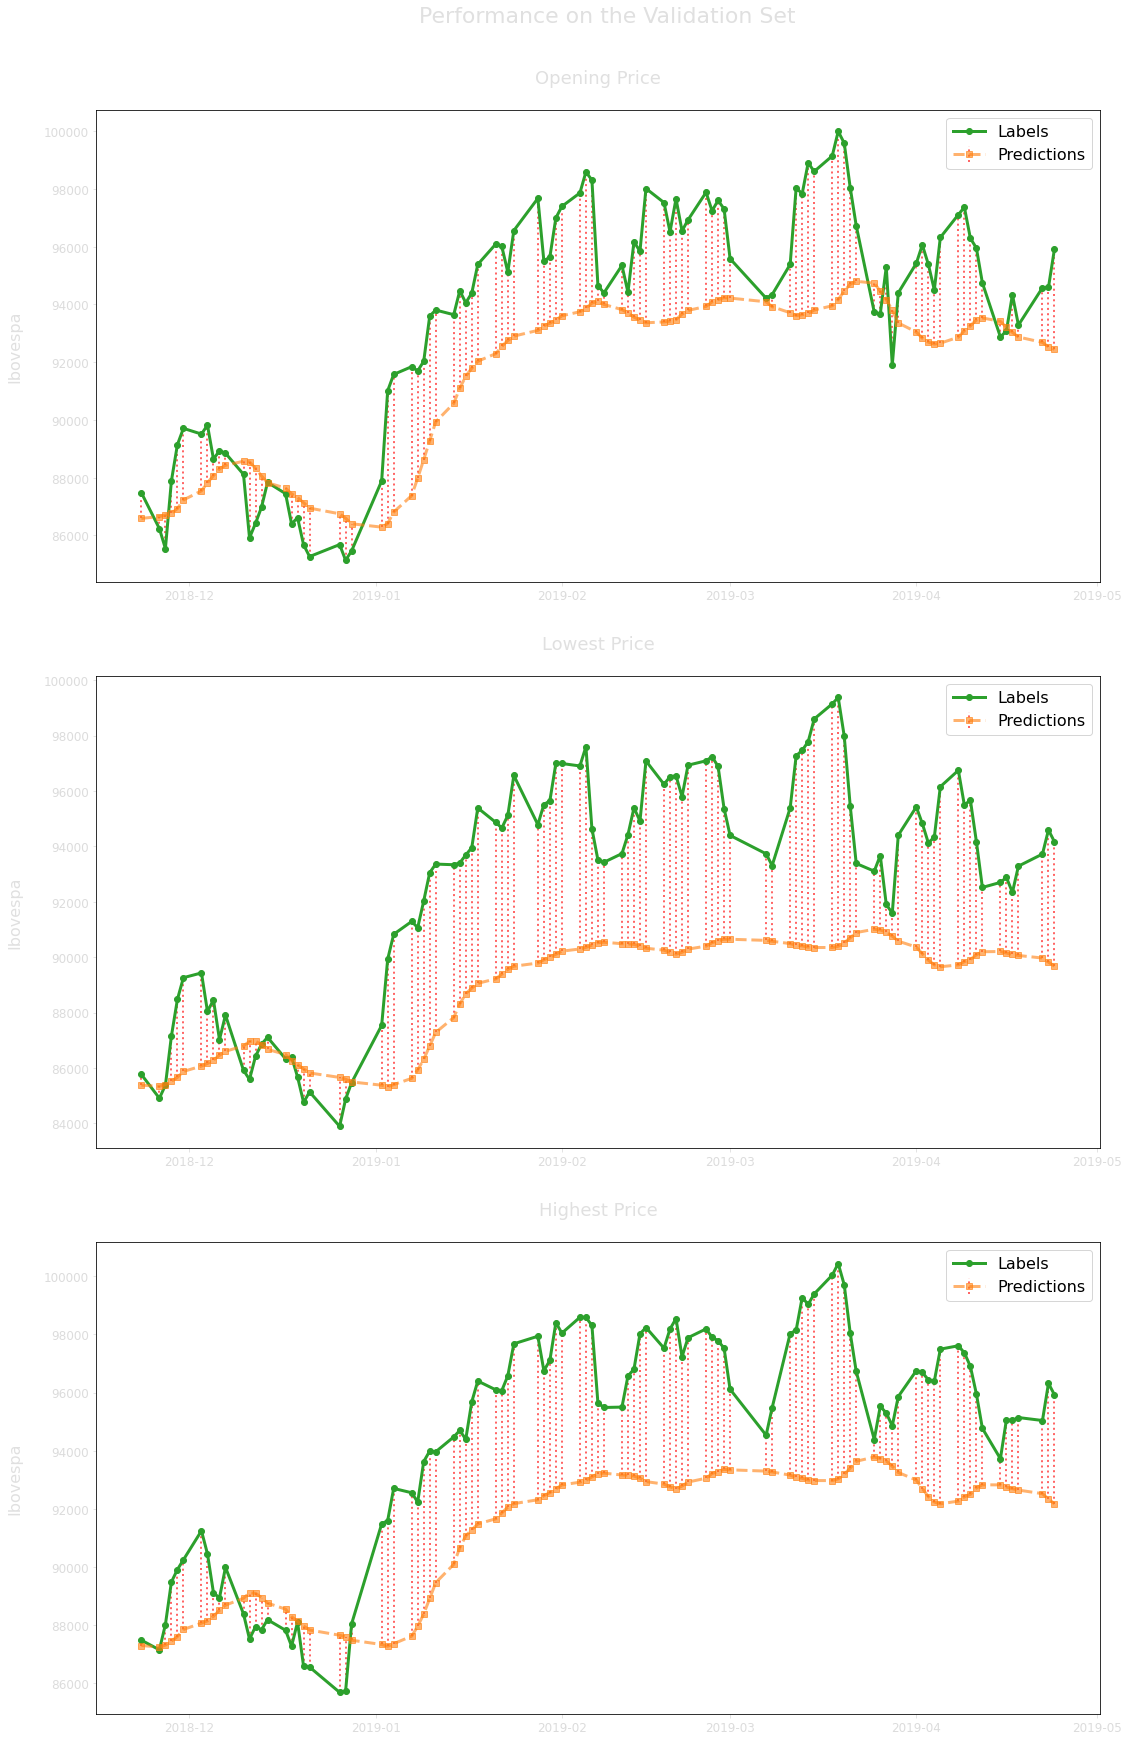

In [31]:
val_predictions, val_results = eval(model, data, "val")

print("     Validation Data\n")
eval_print(val_results)

eval_plot(val_predictions, 
          data.raw_val["labels"], 
          start_date="random", 
          plot_samples=100, 
          title="Performance on the Validation Set")

Javascript("google.colab.output.setIframeHeight('600px');")

#### **3.3) Test data**

     Test Data

#########################

[> GENERAL <]
   . MAE:   2083
   . MAPE:  2.8651%
   . MSE:   13406796

#########################

[> OPEN <]
   . MAE:   2084
   . MAPE:  2.8655%
   . MSE:   13409498
   . Tendency Accuracy:  51.5337%

#########################

[> LOW <]
   . MAE:   2085
   . MAPE:  2.8666%
   . MSE:   13420576
   . Tendency Accuracy:  42.9448%

#########################

[> HIGH <]
   . MAE:   2086
   . MAPE:  2.8675%
   . MSE:   13429263
   . Tendency Accuracy:  47.2393%

#########################


<IPython.core.display.Javascript object>

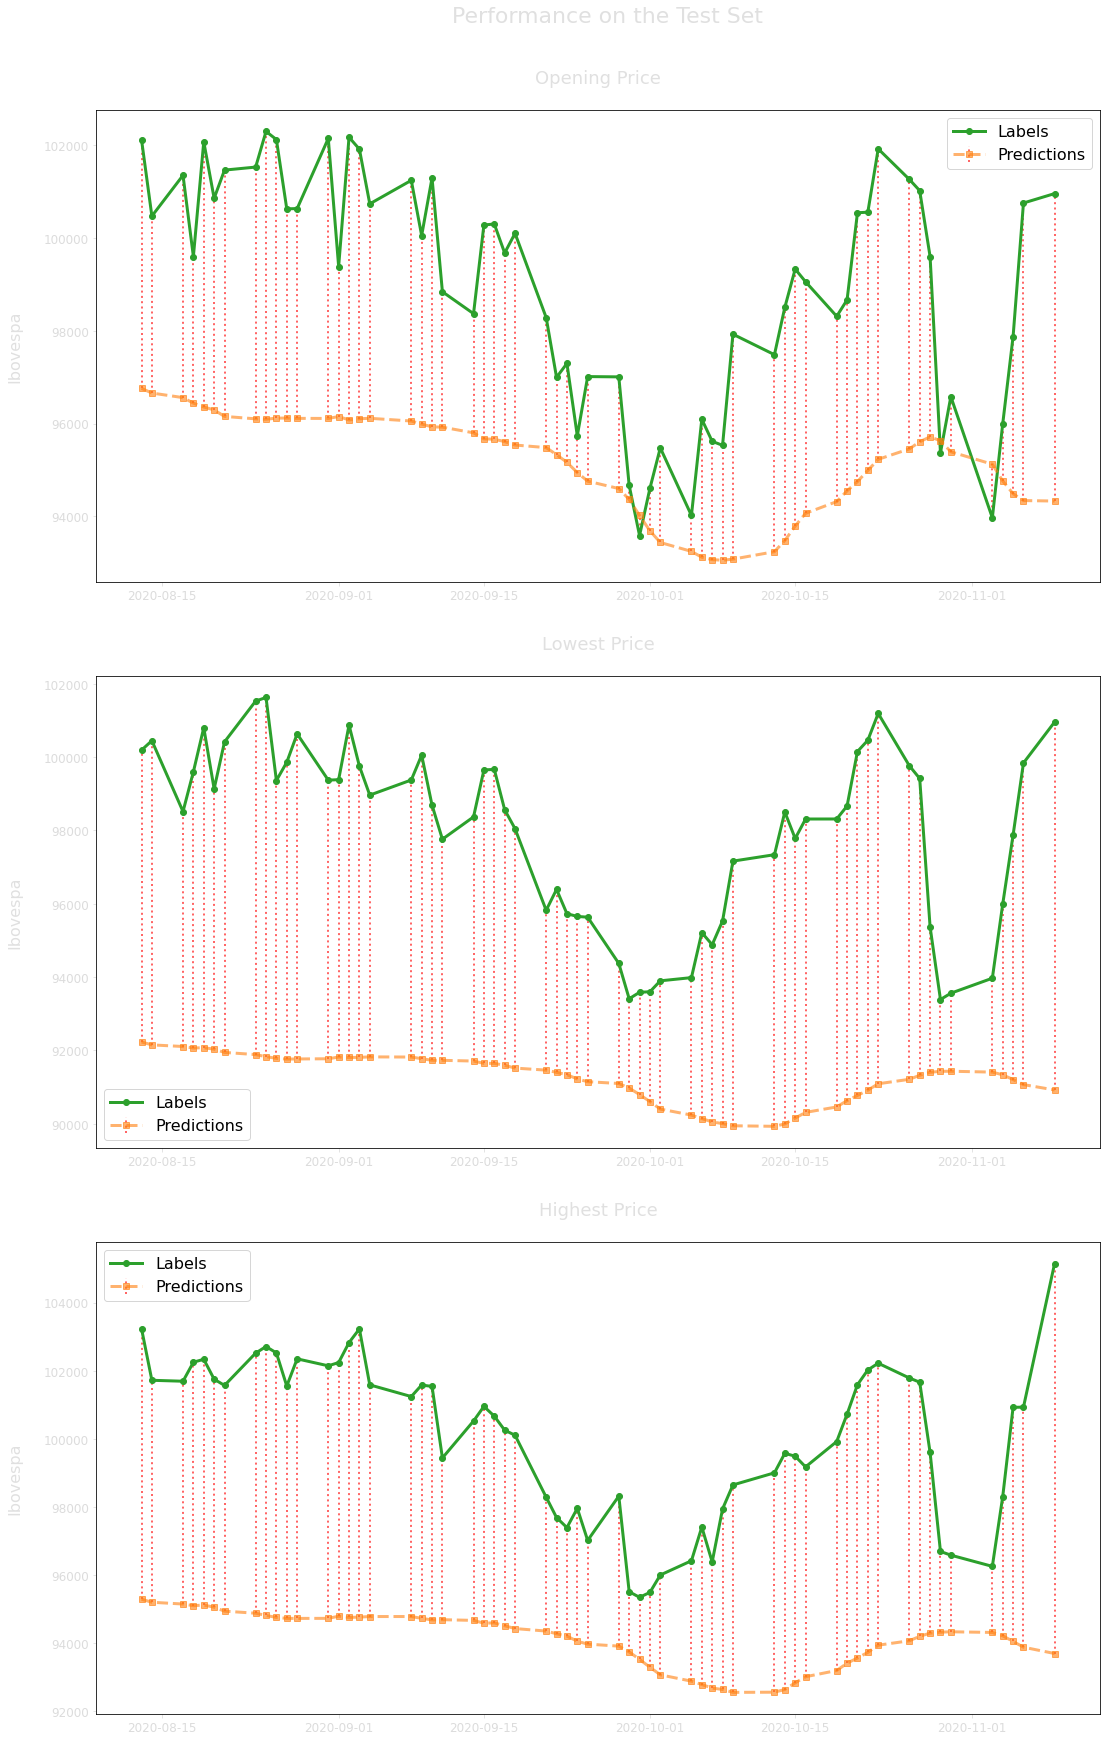

In [32]:
test_predictions, test_results = eval(model, data, "test")

print("     Test Data\n")
eval_print(test_results)

eval_plot(test_predictions, 
          data.raw_test["labels"], 
          start_date="random", 
          plot_samples=60, 
          title="Performance on the Test Set")

Javascript("google.colab.output.setIframeHeight('600px');")